## Lab2: Stochastic Diff Eq w/ Memory ##



In [2]:
# Imports
import numpy as np
import scipy.stats as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import time

In [2]:
def box_muller(size, plot_dist=True):

    U1 = np.random.uniform(size=size)
    U2 = np.random.uniform(size=size)

    r = np.sqrt(-2 * np.log(U1))
    theta = 2*np.pi*U2

    X = r * np.cos(theta)
    Y = r * np.sin(theta)

    n_bins=50
    if plot_dist==True:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
        
        # x-normal
        temp_X = ax1.hist(X, bins=n_bins, density=True, facecolor="gray",alpha=0.5, edgecolor='black')
        mu, sigma = np.mean(X), np.std(X)
        x_range = np.linspace(X.min(), X.max(), 500)
        ax1.plot(x_range, sci.norm.pdf(x_range, mu, sigma), color='black',linestyle="--", lw=1, alpha=0.8)
        
        ax1.set_title("X~N(0,1)", fontsize=10)
        ax1.text(-3.5,0.45,s=f"$\mu$={np.mean(X):.3f}", fontsize=8)
        ax1.text(-3.5,0.4,s=f"$\sigma^{2}$={np.var(X):.3f}", fontsize=8)

        # y-normal
        temp_Y = ax2.hist(Y, bins=n_bins, density=True, facecolor="gray",alpha=0.5, edgecolor='black')
        mu, sigma = np.mean(Y), np.std(Y)
        y_range = np.linspace(Y.min(), Y.max(), 500)
        ax2.plot(y_range, sci.norm.pdf(y_range, mu, sigma), color='black',linestyle="--", lw=1, alpha=0.8)
        
        ax2.set_title("Y~N(0,1)", fontsize=10)
        ax2.text(-3.5,0.45,s=f"$\mu$={np.mean(Y):.3f}", fontsize=8)
        ax2.text(-3.5,0.4,s=f"$\sigma^{2}$={np.var(Y):.3f}", fontsize=8)

        x_line = np.linspace(temp_X[1][0], temp_X[1][-1], len(temp_X[1]))
        y_line = np.linspace(temp_Y[1][0], temp_Y[1][-1], len(temp_Y[1]))
        pdfX = sci.norm.pdf(x_line, 0, 1)
        pdfY = sci.norm.pdf(y_line, 0, 1)

        # lin-log x-norm
        temp = ax3.hist(X, bins=n_bins, density=True, facecolor="gray")
        ax3.set_yscale('log')
        ax3.set_title("lin-log X", fontsize=10)

        #lin-log y-norm
        temp = ax4.hist(Y, bins=n_bins, density=True, facecolor="gray")
        ax4.set_yscale('log')
        ax4.set_title("lin-log Y", fontsize=10)

        ax3.plot(x_line, pdfX, '--', color='black', lw=1)
        ax4.plot(y_line, pdfY, '--', color='black', lw=1)

        
        for ax in [ax1, ax2, ax3, ax4]:
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            if ax==ax1 or ax==ax2:
                ax.set_xlim(-4,4)
            else:
                ax.set_xlim(-5,5)
            ax.set_ylim(0,0.5)
        plt.tight_layout()
        plt.show()
    
    # returns normals, box-muller samples
    print(f"X: mu = <{np.mean(X):.3f}> , var = {np.var(X):.3f}")
    print(f"X: mu = <{np.mean(Y):.3f}> , var = {np.var(Y):.3f}")
    return U1, U2, X, Y

In [3]:
def periodic_boundary(x, y, L):
    # moved to main alg
    x_pbc = ((x + L/2) % L) - L/2
    y_pbc = ((y + L/2) % L) - L/2

    return x_pbc, y_pbc

In [5]:
def euler_mayurama(r, xi, eps, tau, f, dt=1e-3, D=1.0, L=100.0):

    N = r.shape[0]

    # --- OU noise update (Euler–Maruyama) ---
    # xi(t+dt) = xi(t) - (dt/tau) xi(t) + sqrt(2D/tau^2) sqrt(dt) eta
    eta = np.random.randn(N, 2)
    xi += -(dt / tau) * xi + np.sqrt(2 * D / tau**2) * np.sqrt(dt) * eta

    # --- deterministic force along x ---
    F = np.zeros_like(r)
    F[:, 0] = f * eps

    # --- position update ---
    # gamma = 1
    r += (F + xi) * dt

    

    return r, xi

def noise_autocorrelation(xi_traj, store_every=1):
    """
    Compute the noise autocorrelation function C(dt) from xi trajectories.
    
    xi_traj: ndarray of shape (nsteps, N, 2) OR (N, 2) snapshots over time
    store_every: time step spacing if xi_traj is downsampled
    """
    nsteps, N, dim = xi_traj.shape
    max_lag = nsteps // 2  # maximum lag to compute
    C = np.zeros(max_lag)
    
    for lag in range(max_lag):
        # dot product of xi(t) . xi(t+lag)
        prod = np.sum(xi_traj[:nsteps-lag] * xi_traj[lag:], axis=(1,2))  # sum over particles and dims
        C[lag] = np.mean(prod)  # average over time
    t_lags = np.arange(max_lag) * store_every * dt
    return t_lags, C


In [4]:
def initialize(N, L):
    r = np.random.rand(N, 2) * L
    xi = np.zeros((N, 2))
    eps = np.random.choice([-1, 1], size=N)
    return r, xi, eps


In [ ]:
# parameters
N = 100
L = 100.0
D = 1.0
dt = 1e-3
T = 1000.0
nsteps = int(T / dt)

# Persistence times to explore
taus = [1.0, 10.0, 100.0]
_taus=np.arange(10, dtype=float)
taus=np.full_like(_taus,1.0)
#tau=taus[0]
# Force values
forces = [0.0, 1e-3, 1e-2, 1e-1, 1.0]
f=forces[0]

# --- initial conditions ---
r = np.random.rand(N, 2) * L - L/2
xi = np.zeros((N, 2))
eps = np.random.choice([-1, 1], size=N)


msd_all = {}

for tau_idx,tau in enumerate(taus):
    print(f"{tau_idx} {len(taus)}")
    # --- reinitialize for each tau ---
    r = np.random.rand(N, 2) * L - L/2
    xi = np.zeros((N, 2))

    traj = np.zeros((nsteps, N, 2))
    disp = np.zeros((nsteps, N, 2))

    for k in range(1, nsteps):
        traj[k] = r
        r_old = r.copy()
        r, xi = euler_mayurama(r, xi, eps, tau, f, dt=dt, D=D, L=L)
        disp[k] = disp[k-1] + (r - r_old)
        if (k+1)%250000==0:
            print(f"{k+1}/{nsteps} {((k+1)/nsteps)*100:.2f}%")

    # --- MSD from unwrapped displacement ---
    msd = np.mean(np.sum(disp**2, axis=2), axis=1)
    msd_all[tau_idx] = msd

In [ ]:
# parameters
N = 100
L = 100.0
D = 0.01
dt = 1e-2
T = 10000.0
nsteps = int(T / dt)
t0=time.time()
# Persistence times to explore
taus = [1.0, 10.0, 100.0]
_taus=np.arange(15, dtype=float)
taus=np.full_like(_taus,10.0)
#taus[10:]*=10
#taus[20:]*=10
#tau=taus[0]
# Force values
forces = [0.0, 1e-3, 1e-2, 1e-1, 1.0]
f=forces[0]

# --- initial conditions ---
r = np.random.rand(N, 2) * L - L/2
xi = np.zeros((N, 2))
eps = np.random.choice([-1, 1], size=N)
store_every = 100
nstore = nsteps // store_every
xi_traj = np.zeros((nstore, N, 2), dtype=np.float32)
msd_all = {}
noise_corr = {}
msd_x_all = {}
dx_all = {}
for tau_idx, tau in enumerate(taus):
    tautime=time.time()
    print(f"Running tau {tau_idx+1}/{len(taus)}: tau = {tau} {int((time.time()-t0)//60)}:{(time.time()-t0)%60:.2f}")

    # Initialize positions and OU noise
    r = np.random.rand(N, 2) * L - L/2
    xi = np.zeros((N, 2))
    disp = np.zeros((N, 2))
    msd_x = np.zeros(nstore, dtype=np.float32)
    dx = np.zeros(nstore, dtype=np.float32)
    msd = np.zeros(nstore, dtype=np.float32)
    store_idx = 0

    for k in range(1, nsteps + 1):
        r_old = r.copy()
        r, xi = euler_mayurama(r, xi, eps, tau, f, dt=dt, D=D, L=L)
        disp += (r - r_old)
        # --- periodic boundary conditions (your convention) ---
        r[:, 0] = ((r[:, 0] + L/2) % L) - L/2
        r[:, 1] = ((r[:, 1] + L/2) % L) - L/2
        # Store MSD every store_every steps
        if k % store_every == 0:
            dx_i = disp[:, 0]               # unwrapped x displacement
            msd_x[store_idx] = np.mean(dx_i**2)
            msd[store_idx] = np.mean(np.sum(disp**2, axis=1))
            xi_traj[store_idx] = xi
            store_idx += 1

        # Optional: progress print
        if k % 250000 == 0:
            print(f"  Step {k}/{nsteps} ({(k/nsteps)*100:.2f}%) {int((time.time()-tautime)//60)}:{(time.time()-tautime)%60:.2f}")
    t_lags, C_xi = noise_autocorrelation(xi_traj, store_every=store_every)
    noise_corr[tau_idx]=(t_lags,C_xi)
    msd_all[tau_idx] = msd
    msd_x_all[tau_idx] = msd_x
    dx_all[tau_idx] = dx


Running tau 1/30: tau = 10.0 0:0.01
  Step 250000/1000000 (25.00%) 0:7.31


KeyboardInterrupt: 

In [97]:
# parameters
N = 100
L = 100.0
D = 0.01
dt = 1e-2
T = 1000.0
nsteps = int(T / dt)
t0=time.time()
# Persistence times to explore
_taus=np.arange(10, dtype=float)
tau=10
# Force values
forces = [0.0, 1e-3, 1e-2, 1e-1, 1.0]

# --- initial conditions ---
r = np.random.rand(N, 2) * L - L/2
xi = np.zeros((N, 2))
eps = np.random.choice([-1, 1], size=N)
store_every = 100
nstore = nsteps // store_every
xi_traj = np.zeros((nstore, N, 2), dtype=np.float32)
nrealizations = 10  # number of independent runs per force

# storage dictionaries for all realizations
msd_all = {f: [] for f in forces}
msd_x_all = {f: [] for f in forces}
dx_all = {f: [] for f in forces}
noise_corr = {f: [] for f in forces}

for f_idx, f in enumerate(forces):
    for realization in range(nrealizations):
        ftime = time.time()
        print(
            f"Running force {f_idx+1}/{len(forces)}, realization {realization+1}/{nrealizations}: "
            f"f = {f} {int((time.time()-t0)//60)}:{(time.time()-t0)%60:.2f}"
        )

        # Initialize positions and OU noise
        r = np.random.rand(N, 2) * L - L/2
        xi = np.zeros((N, 2))
        eps = np.random.choice([-1, 1], size=N)
        disp = np.zeros((N, 2))
        xi_traj = np.zeros((nstore, N, 2), dtype=np.float32)

        msd_x = np.zeros(nstore, dtype=np.float32)
        dx = np.zeros(nstore, dtype=np.float32)
        msd = np.zeros(nstore, dtype=np.float32)
        store_idx = 0

        for k in range(1, nsteps + 1):
            r_old = r.copy()
            r, xi = euler_mayurama(r, xi, eps, tau, f, dt=dt, D=D, L=L)
            disp += (r - r_old)

            # periodic boundary conditions
            r[:, 0] = ((r[:, 0] + L/2) % L) - L/2
            r[:, 1] = ((r[:, 1] + L/2) % L) - L/2

            if k % store_every == 0:
                dx_i = disp[:, 0]                 # unwrapped x displacement
                msd_x[store_idx] = np.mean(dx_i**2)
                dx[store_idx] = np.mean(eps * dx_i)
                msd[store_idx] = np.mean(np.sum(disp**2, axis=1))
                xi_traj[store_idx] = xi
                store_idx += 1

            if k % 250_000 == 0:
                print(
                    f"  Step {k}/{nsteps} ({(k/nsteps)*100:.2f}%) "
                    f"{int((time.time()-ftime)//60)}:{(time.time()-ftime)%60:.2f}"
                )

        t_lags, C_xi = noise_autocorrelation(xi_traj, store_every=store_every)

        # store per realization
        noise_corr[f].append((t_lags, C_xi))
        msd_all[f].append(msd)
        msd_x_all[f].append(msd_x)
        dx_all[f].append(dx)

Running force 1/5, realization 1/10: f = 0.0 0:0.00
Running force 1/5, realization 2/10: f = 0.0 0:3.01
Running force 1/5, realization 3/10: f = 0.0 0:5.82
Running force 1/5, realization 4/10: f = 0.0 0:8.80
Running force 1/5, realization 5/10: f = 0.0 0:11.74
Running force 1/5, realization 6/10: f = 0.0 0:14.67
Running force 1/5, realization 7/10: f = 0.0 0:17.57
Running force 1/5, realization 8/10: f = 0.0 0:20.40
Running force 1/5, realization 9/10: f = 0.0 0:23.23
Running force 1/5, realization 10/10: f = 0.0 0:26.20
Running force 2/5, realization 1/10: f = 0.001 0:29.07
Running force 2/5, realization 2/10: f = 0.001 0:31.97
Running force 2/5, realization 3/10: f = 0.001 0:34.87
Running force 2/5, realization 4/10: f = 0.001 0:37.72
Running force 2/5, realization 5/10: f = 0.001 0:40.64
Running force 2/5, realization 6/10: f = 0.001 0:43.51
Running force 2/5, realization 7/10: f = 0.001 0:46.50
Running force 2/5, realization 8/10: f = 0.001 0:49.36
Running force 2/5, realization 9/

In [116]:
taus_to_test = [1.0, 2.5, 5.0, 8.0, 10.0, 15.0,20.0,25.0,30.0]  # persistence times to explore
taus_to_test=[1,2,5,10,15,25,50]
nrealizations = 6               # number of independent runs per force
# parameters
N = 100
L = 100.0
D = 0.01
dt = 1e-2
T = 1000.0
nsteps = int(T / dt)
t0=time.time()
# Force values
forces = [1e-3, 5e-3, 1e-2]

# --- initial conditions ---
r = np.random.rand(N, 2) * L - L/2
xi = np.zeros((N, 2))
eps = np.random.choice([-1, 1], size=N)
store_every = 100
nstore = nsteps // store_every
# storage dictionaries
msd_all = {tau: {f: [] for f in forces} for tau in taus_to_test}
msd_x_all = {tau: {f: [] for f in forces} for tau in taus_to_test}
dx_all = {tau: {f: [] for f in forces} for tau in taus_to_test}

for tau in taus_to_test:
    print(f"Running simulations for tau = {tau}")
    for _f,f in enumerate(forces):
        for realization in range(nrealizations):
            print(
            f"Running force {_f+1}/{len(forces)}, realization {realization+1}/{nrealizations}: "
            f"f = {f} {int((time.time()-t0)//60)}:{(time.time()-t0)%60:.2f}"
            )
            # Initialize positions and OU noise
            r = np.random.rand(N, 2) * L - L/2
            xi = np.zeros((N, 2))
            eps = np.random.choice([-1, 1], size=N)
            disp = np.zeros((N, 2))

            msd_x = np.zeros(nstore, dtype=np.float32)
            dx = np.zeros(nstore, dtype=np.float32)
            #msd = np.zeros(nstore, dtype=np.float32)
            store_idx = 0

            for k in range(1, nsteps + 1):
                r_old = r.copy()
                r, xi = euler_mayurama(r, xi, eps, tau, f, dt=dt, D=D, L=L)
                disp += (r - r_old)

                # periodic boundary conditions
                r[:, 0] = ((r[:, 0] + L/2) % L) - L/2
                r[:, 1] = ((r[:, 1] + L/2) % L) - L/2

                if k % store_every == 0:
                    dx_i = disp[:, 0]                 # unwrapped x displacement
                    msd_x[store_idx] = np.mean(dx_i**2)
                    dx[store_idx] = np.mean(eps * dx_i)
                    #msd[store_idx] = np.mean(np.sum(disp**2, axis=1))
                    store_idx += 1
                if k % 25000 == 0:
                    print(
                        f"({(k/nsteps)*100:.2f}%) "
                        f"{int((time.time()-ftime)//60)}:{(time.time()-ftime)%60:.2f}"
                    )

            # store results per realization
            #msd_all[tau][f].append(msd)
            msd_x_all[tau][f].append(msd_x)
            dx_all[tau][f].append(dx)


Running simulations for tau = 1
Running force 1/3, realization 1/6: f = 0.001 0:0.02
(25.00%) 61:40.73
(50.00%) 61:41.44
(75.00%) 61:42.15
(100.00%) 61:43.01
Running force 1/3, realization 2/6: f = 0.001 0:3.02
(25.00%) 61:43.72
(50.00%) 61:44.43
(75.00%) 61:45.19
(100.00%) 61:45.96
Running force 1/3, realization 3/6: f = 0.001 0:5.97
(25.00%) 61:46.67
(50.00%) 61:47.37
(75.00%) 61:48.07
(100.00%) 61:48.78
Running force 1/3, realization 4/6: f = 0.001 0:8.79
(25.00%) 61:49.48
(50.00%) 61:50.18
(75.00%) 61:50.88
(100.00%) 61:51.58
Running force 1/3, realization 5/6: f = 0.001 0:11.60
(25.00%) 61:52.29
(50.00%) 61:52.99
(75.00%) 61:53.69
(100.00%) 61:54.40
Running force 1/3, realization 6/6: f = 0.001 0:14.41
(25.00%) 61:55.10
(50.00%) 61:55.81
(75.00%) 61:56.51
(100.00%) 61:57.22
Running force 2/3, realization 1/6: f = 0.005 0:17.23
(25.00%) 61:57.97
(50.00%) 61:58.70
(75.00%) 61:59.42
(100.00%) 62:0.13
Running force 2/3, realization 2/6: f = 0.005 0:20.15
(25.00%) 62:0.85
(50.00%) 62:1

<Figure size 600x400 with 0 Axes>

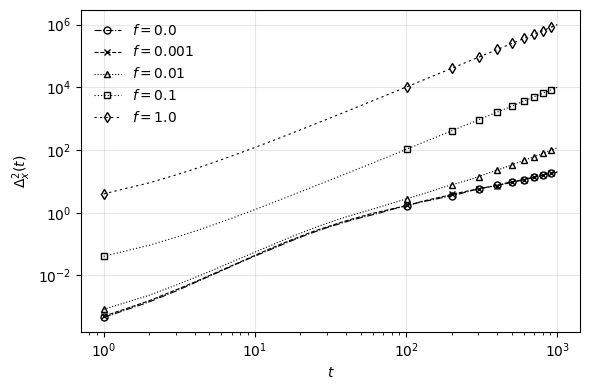

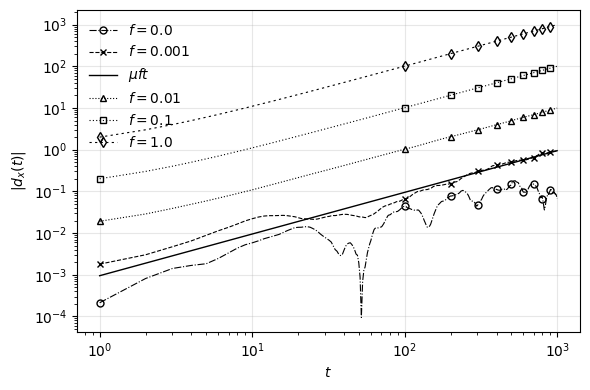

In [ ]:
# --- time array ---
t = np.arange(nstore) * store_every * dt
skip = 1

plt.figure(figsize=(6,4))

linestyles = ['dashdot','dashed','dotted',(0,(1,2)),(0,(2,3)),(0,(3,5))]
markers=['o','x','^','s','d']

# stacked means
msd_x_array = np.array([msd_x_all[i] for i in forces])

markevery = (0, 100)


# --- MSD_x plot ---
plt.figure(figsize=(6,4))
for f_idx, f in enumerate(forces):
    # average over realizations
    msd_x_mean = np.mean(msd_x_all[f], axis=0)
    plt.loglog(
        t[skip:], msd_x_mean[skip:],
        marker=markers[f_idx % len(markers)],
        markersize=5, markevery=markevery,
        fillstyle='none',
        linestyle=linestyles[f_idx % len(linestyles)],
        linewidth=0.8,
        color='black',
        label=rf"$f={f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\Delta_x^2(t)$")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- d_x(t) plot ---
plt.figure(figsize=(6,4))
for f_idx, f in enumerate(forces):
    # average over realizations
    dx_mean = np.mean(dx_all[f], axis=0)
    plt.loglog(
        t[skip:], np.abs(dx_mean[skip:]),
        marker=markers[f_idx % len(markers)],
        markersize=5, markevery=markevery,
        fillstyle='none',
        linestyle=linestyles[f_idx % len(linestyles)],
        linewidth=0.8,
        color='black',
        label=rf"$f={f}$"
    )

    # optional: overlay linear-response slope for small f (example f=1e-3)
    if f == 1e-3:
        mu_est = dx_mean[-1] / (f * t[-1])
        plt.loglog(t[skip:], mu_est * f * t[skip:], '-', color='black', linewidth=1, label=r"$\mu f t$")

plt.xlabel(r"$t$")
plt.ylabel(r"$|d_x(t)|$")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


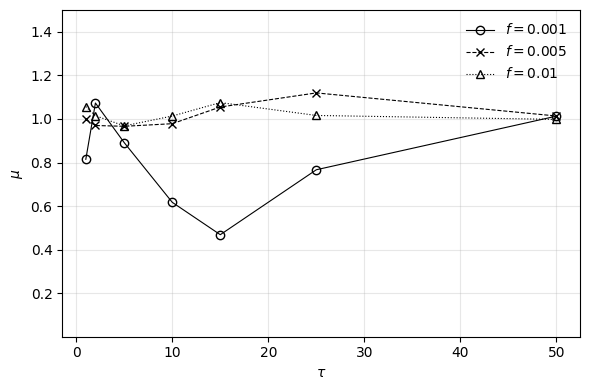

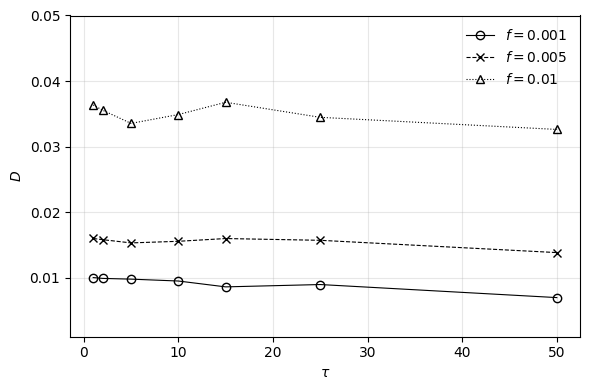

In [120]:
# --- time array ---
t = np.arange(nstore) * store_every * dt
tmask = t > 5  # late-time regime

linestyles = ['solid','dashed','dotted','dashdot']
markers = ['o','x','^','s']

# --- μ vs tau ---
plt.figure(figsize=(6,4))
for f_idx, f in enumerate(forces):
    mu_vals = []
    for tau in taus_to_test:
        # average over runs first
        dx_mean = np.mean(dx_all[tau][f], axis=0)
        mu = np.mean(dx_mean[tmask] / (f * t[tmask]))
        mu_vals.append(mu)
    plt.plot(taus_to_test, mu_vals,
             marker=markers[f_idx % len(markers)],
             linestyle=linestyles[f_idx % len(linestyles)],
             linewidth=0.8,
             fillstyle='none',
             color='black',
             label=rf"$f={f}$")

plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mu$")
plt.grid(alpha=0.3)
plt.ylim(0.001,1.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- D vs tau ---
plt.figure(figsize=(6,4))
for f_idx, f in enumerate(forces):
    D_vals = []
    for tau in taus_to_test:
        msd_x_mean = np.mean(msd_x_all[tau][f], axis=0)
        D_est = np.mean(msd_x_mean[tmask] / (2 * t[tmask]))
        D_vals.append(D_est)
    plt.plot(taus_to_test, D_vals,
               marker=markers[f_idx % len(markers)],
               linestyle=linestyles[f_idx % len(linestyles)],
               linewidth=0.8,
               fillstyle='none',
               color='black',
               label=rf"$f={f}$")

plt.xlabel(r"$\tau$")
plt.ylabel(r"$D$")
plt.ylim(0.001,0.05)
plt.grid(alpha=0.3)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
plt.show()



In [ ]:

# --- Signed displacement d_x(t) ---
plt.figure(figsize=(6,4))
for f_idx, f in enumerate(forces):
    # individual realizations
    plt.loglog(t[skip:], np.abs(dx_all[f_idx][skip:]), color='black', alpha=0.2,
               linewidth=0.8, linestyle=linestyles[f_idx])
dx_array = np.array([dx_all[i] for i in range(len(forces))])
for f_idx, f in enumerate(forces):
    mean_dx = np.mean(dx_array[f_idx::len(forces), skip:], axis=0)
    plt.loglog(t[skip:], np.abs(mean_dx),
               marker=markers[f_idx], markersize=5, markevery=markevery,
               fillstyle='none',linestyle=linestyles[f_idx], linewidth=0.8,
               color='black', label=rf"$f={f}$")
    # overlay linear-response slope for small f (example: f=1e-3)
    if f==1e-3:
        mu_est = mean_dx[-1]/(f*t[-1])  # approximate μ from last point
        plt.loglog(t[skip:], mu_est*f*t[skip:], '-', color='black', linewidth=1,
                   label=r"$\mu f t$")
plt.xlabel(r"$t$")
plt.ylabel(r"$|d_x(t)|$")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


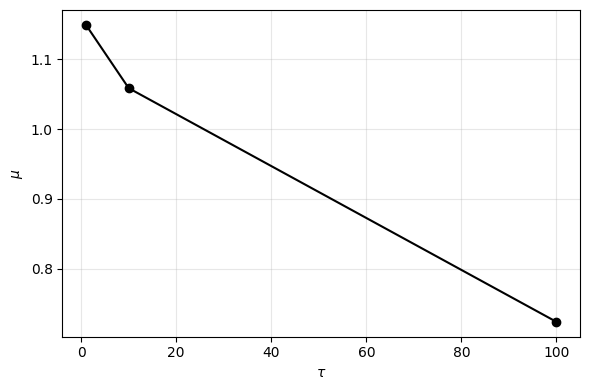

TypeError: unsupported operand type(s) for /: 'float' and 'list'

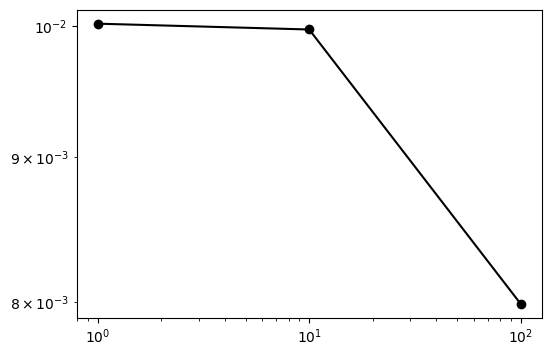

In [94]:

# --- μ and D vs τ ---
f_small = 1e-3
t = np.arange(nstore) * store_every * dt
tmask = t > 5 * tau  # late-time linear regime

mu_vals = []
D_vals = []
for tau in taus_to_test:
    dx_mean = np.mean(dx_all[tau][f_small], axis=0)
    msd_x_mean = np.mean(msd_x_all[tau][f_small], axis=0)
    mu_vals.append(np.mean(dx_mean[tmask]/(f_small*t[tmask])))
    D_vals.append(np.mean(msd_x_mean[tmask]/(2*t[tmask])))

plt.figure(figsize=(6,4))
plt.plot(taus_to_test, mu_vals, 'o-', color='black', label=r"$\mu$")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mu$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.loglog(taus_to_test, D_vals, 'o-', color='black', label=r"$D$")
plt.loglog(taus_to_test, D/taus_to_test, '--', color='black', label=r"$D/\tau$")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$D$")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [ ]:


# individual realizations
for f_idx, f in enumerate(forces):
    plt.loglog(
        t[skip:], np.abs(dx_all[f_idx][skip:]),
        color='black', alpha=0.2, linewidth=0.8,
        linestyle=linestyles[f_idx]
    )

# stacked means
dx_array = np.array([dx_all[i] for i in range(len(forces))])

for f_idx, f in enumerate(forces):
    plt.loglog(
        t[skip:], np.abs(np.mean(dx_array[f_idx::len(forces), skip:], axis=0)),
        marker='x', markersize=5, markevery=markevery,
        linestyle='--', linewidth=0.8,
        color='black', label=rf"$f={f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$|d_x(t)|$")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

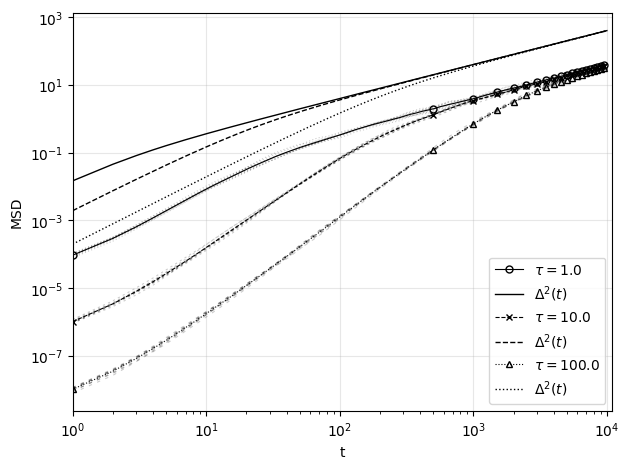

In [ ]:
def msd_theory(t, D, tau):
    return 4 * D * (t + tau * (np.exp(-t / tau) - 1))
# --- time array ---
plt.figure()
t = np.arange(len(msd_all[0]))
skip=1
linestyles = [(0,(1,2))] * 10 + [(0,(2,3))] * 10 + [(0,(3,5))] * 10

for tau_idx, tau in enumerate(taus):
    plt.loglog(t[skip:], msd_all[tau_idx][skip:],color='black',alpha=0.2, linewidth=0.8, linestyle=linestyles[tau_idx])#,label=f"sim τ={tau}")
    
msd_array = np.array([msd_all[tau_idx] for tau_idx in range(len(taus))])

markevery = (0,500) # increase to skip more markers

plt.loglog(
    t[skip:], np.mean(msd_array[:10, skip:], axis=0),
    marker='o', markersize=5, markevery=markevery,
    fillstyle='none', linestyle='-', linewidth=0.8,
    label=rf"$\tau=${taus[0]}", color='black'
)
plt.loglog(t[skip:],msd_theory(t, D, taus[0])[skip:], linestyle='-', linewidth=1,color='black',label=r"$\Delta^2 (t)$")

plt.loglog(
    t[skip:], np.mean(msd_array[10:20, skip:], axis=0),
    marker='x', markersize=5, markevery=markevery,
    linestyle='--', linewidth=0.8,
    label=rf"$\tau=${taus[10]}", color='black'
)
plt.loglog(t[skip:],msd_theory(t, D, taus[10])[skip:], linestyle='--', linewidth=1,color='black',label=r"$\Delta^2 (t)$")
plt.loglog(
    t[skip:], np.mean(msd_array[20:, skip:], axis=0),
    marker='^', markersize=5, markevery=markevery,
    fillstyle='none', linestyle=':', linewidth=0.8,
    label=rf"$\tau=${taus[20]}", color='black'
)
plt.loglog(t[skip:],msd_theory(t, D, taus[20])[skip:], linestyle=':', linewidth=1,color='black',label=r"$\Delta^2 (t)$")

plt.xlabel("t")
plt.ylabel("MSD")
plt.legend()
plt.xlim(1,11000)
plt.grid( alpha=0.3)
plt.tight_layout()
plt.show()

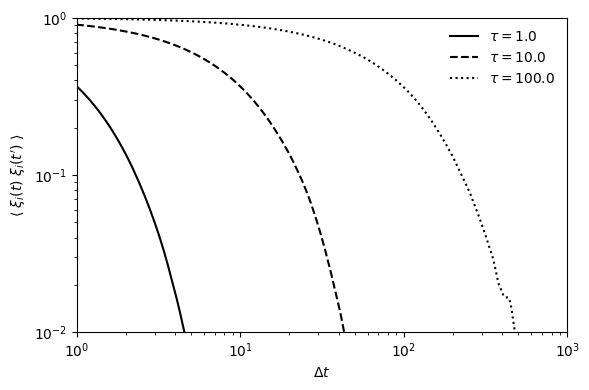

In [68]:
unique_taus = np.unique(taus)

plt.figure(figsize=(6,4))
ls=['-',"--",":"]
for _tau,tau in enumerate(unique_taus):
    idx = np.where(taus == tau)[0]

    C_stack = []
    for i in idx:
        t_lags, C_xi = noise_corr[i]
        C_stack.append(C_xi / C_xi[0])

    C_stack = np.vstack(C_stack)
    C_mean = C_stack.mean(axis=0)

    plt.loglog(
        t_lags, C_mean,
        color='black', linewidth=1.5,
        label=rf"$\tau={tau}$", linestyle=ls[_tau]
    )

plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\langle\ \xi_i (t)\ \xi_i (t')\ \rangle$")
plt.legend(frameon=False)
plt.ylim(0.01,1)
plt.xlim(1,1000)
plt.tight_layout()
plt.show()